Multimodal Semi-supervised Learning Framework for Punctuation Prediction
in Conversational Speech, Sunkara et al., 2020

# Multimodal Semi-supervised learning architecture (MuSe)

An architecture that uses Lexical and Acoustic pretrained encoders, then combine their output embeddings using an attention-based fusion technique.

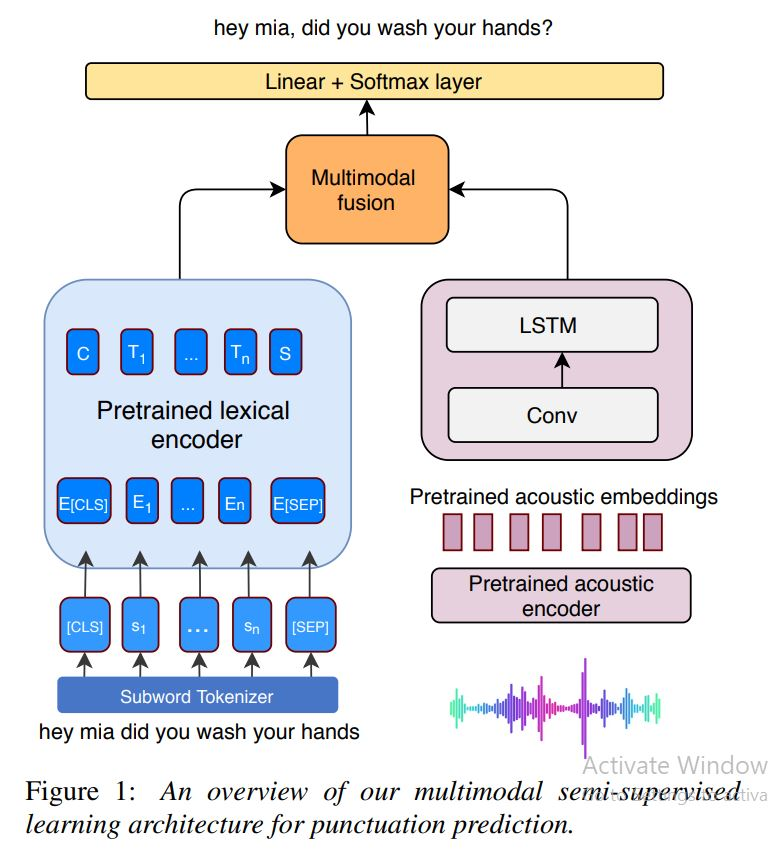

In [ ]:
!nvidia-smi

Wed Jun  8 10:11:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%%capture
!pip install datasets[audio] transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /

/


In [ ]:
%cp -r '/content/drive/MyDrive/Colab Notebooks/MuSe notebook models/huggingface' root/.cache

In [ ]:
%cd /root/.cache/huggingface
%ls

/root/.cache/huggingface
transformers/


In [ ]:
import torch
import numpy as np
from math import ceil
import torchaudio
import torch.nn.functional as F

# Loading Dataset

## Utility functions

In [ ]:
# loading YAML file into a list of dictionaries
import yaml

def read_yaml(path):
  yaml_file = None
  with open(path, "r") as stream:
      try:
          yaml_file = yaml.safe_load(stream)
      except yaml.YAMLError as exc:
          print(exc)
  return yaml_file

In [ ]:
import re

def remove_special_characters(s):
    chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"\—]'
    s = re.sub(chars_to_ignore_regex, '', s).lower()
    s = re.sub(r'[0-9]+', '', s)
    s = re.sub(' +', ' ', s)
    return s

def clean_target_text(s):
    chars_to_ignore_regex = '[\!\-\;\:\"\—]'
    new_s = re.sub(chars_to_ignore_regex, '', s).lower()
    list_s = list(s)
    delete_indices = []
    for i in range(len(s)):
        if(i > 0 and i < len(s) and s[i] in [',', '.', '?'] and s[i-1].isdigit() and s[i+1].isdigit()):
            delete_indices.append(i)
    
    for i in sorted(delete_indices, reverse=True):
        list_s.pop(i)
    new_s = "".join(list_s)
    # print(new_s)
    new_s = re.sub(r'[0-9]+', '', new_s)
    new_s = re.sub(' +', ' ', new_s)

    return new_s

Punctuation labels dictionary

In [ ]:
from collections import defaultdict
punct_labels_dict = defaultdict(lambda : '<O>')
punct_labels_dict[','] = '<COMMA>'
punct_labels_dict['.'] = '<PERIOD>'
punct_labels_dict['?'] = '<QUESTION>'

This function converts the text to punctuation labels

In [ ]:
# 1. tokenize into subwords using same tokenizer as source text
# 2. add labels to tokenized target text 
def text2label(text: str, tokenizer):
    tokens = tokenizer.tokenize(clean_target_text(text))
    # labels = ['<O>']
    labels = []
    for i, token in enumerate(tokens):
        # print(i, len(labels), token)
        if(punct_labels_dict[token] != '<O>' and len(labels) > 0):
                labels[-1] = punct_labels_dict[token]
        else:
            labels.append(punct_labels_dict[token])
    # labels.append('<O>')
    return ['<O>'] + labels + ['<O>']

# CHANGE THIS
def punct_labels_to_embedding(labels):
    emb = []
    for label in labels:
        if label == '<O>':
            # emb.append([1,0,0,0])
            emb.append(0)
        elif label == '<COMMA>':
            emb.append(1)
            # emb.append([0,1,0,0])
        elif label == '<PERIOD>':
            emb.append(2)
            # emb.append([0,0,1,0])
        elif label == '<QUESTION>':
            emb.append(3)
            # emb.append([0,0,0,1])
        else:
            emb.append(-100)
            # emb.append([0,0,0,0])

    return torch.tensor(emb)

def text_to_punct_embedding(text, tokenizer):
    return punct_labels_to_embedding(text2label(text, tokenizer))

In [ ]:
# st = 'Don\'t you dare?   "tokenize" I dare. do you?'

In [ ]:
# labels = text2label(st, lexical_encoder.tokenizer)
# print(len(labels), labels)

In [ ]:
# punct_labels_to_embedding(labels)

In [ ]:
# text_to_punct_embedding(st, lexical_encoder.tokenizer).shape

In [ ]:
# <O> <O> <FS> <O> <C> <O> <Q> <?>
# 0    0   1   0    2   0   3  -100
# 

This method takes a dataset entry, and returns its corresponding audio segment

In [ ]:
def getAudioSegment(data, parent_path):
    path = parent_path + data['file']
    audio_tensor, rate = torchaudio.load(path)
    audio = audio_tensor.numpy().transpose().flatten()
    audio = torch.FloatTensor(audio[data['start']:data['end']])
    del audio_tensor, path
    return audio

Loading lexical encoder needed for dataset loading

In [ ]:
from transformers import DistilBertTokenizer, DistilBertModel

lexical_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
lexical_model = DistilBertModel.from_pretrained("distilbert-base-uncased")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Loading training data

In [ ]:
path = "/content/drive/MyDrive/en-de/data/train/txt/train.yaml"
yaml_file = read_yaml(path)

In [ ]:
en_file = open("/content/drive/MyDrive/en-de/data/train/txt/train.en", "r")

In [ ]:
current_wav = ""
audio, rate = None, 16000
train_data_list = []

cnt = -1
for line_props in yaml_file:
  english_text = en_file.readline()[:-2]
  cnt += 1
#   if cnt < 0:
#       continue
#   elif cnt == 200000:
#     break

#   if cnt % 1000 == 0:
#       print(cnt)
  
  entry_dict = {}
  if line_props['wav'] != current_wav:
    current_wav = line_props['wav']
#     try:
#       audio_tensor, rate = torchaudio.load("/content/drive/MyDrive/en-de/data/train/wav/"+current_wav)
#     except Exception as ex:
#       print(ex)
#       continue
#     audio = audio_tensor.numpy().transpose().flatten()
  
  punctuated_text = english_text
  reference = remove_special_characters(punctuated_text)
  if(len(reference.split(' ')) < 6):
      continue

  offset = line_props['offset']
  duration = line_props['duration']
  start = int(offset*rate)
  end = int( ceil( (offset*rate)+(duration*rate) ))

  entry_dict['file'] = current_wav
#   entry_dict['audio'] = audio[start:end]
  entry_dict['start'] = start
  entry_dict['end'] = end
  entry_dict['raw_text'] = punctuated_text
  entry_dict['text'] = reference
#   entry_dict['target'] = clean_target_text(punctuated_text)
  train_data_list.append(entry_dict)

In [ ]:
import pandas as pd

# df_train = pd.DataFrame(train_data_list)
# df_train.to_csv('/content/drive/MyDrive/en-de/all_chosen_data.csv')
# train_data_list = None

df_train = pd.read_csv('/content/drive/MyDrive/en-de/all_chosen_data.csv')
df_train.drop(axis=1, columns = [df_train.columns[0]], inplace=True)
df_train.head() 

,file,start,end,raw_text,text
0,ted_1.wav,98720,559520,And it's truly a great honor to have the oppor...,and it's truly a great honor to have the oppor...
1,ted_1.wav,560160,779200,"And I say that sincerely, partly because (Mock...",and i say that sincerely partly because (mock ...
2,ted_1.wav,779200,1146400,Now I have to take off my shoes or boots to ge...,now i have to take off my shoes or boots to ge...
3,ted_1.wav,1161600,1227520,I'll tell you one quick story to illustrate wh...,i'll tell you one quick story to illustrate wh...
4,ted_1.wav,1235520,1363840,It's a true story — every bit of this is true....,it's a true story every bit of this is true so...


In [ ]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(df_train[:15000])
# train_dataset = train_dataset.shuffle(seed = 42)
# df_train = None
print(train_dataset)

Dataset({
    features: ['file', 'start', 'end', 'raw_text', 'text'],
    num_rows: 15000
})


In [ ]:
import gc
gc.collect()

169

## Loading Validation data

In [ ]:
# making validation dataset size = 25% of the train dataset size
df_val = df_train[20000 : 23750]

valid_dataset = Dataset.from_pandas(df_val)
print(valid_dataset)

Dataset({
    features: ['file', 'start', 'end', 'raw_text', 'text'],
    num_rows: 3750
})


## Loading Test data

In [ ]:
path = "/content/drive/MyDrive/en-de/data/tst-HE/txt/tst-HE.yaml"
yaml_file = read_yaml(path)

In [ ]:
en_file = open("/content/drive/MyDrive/en-de/data/tst-HE/txt/tst-HE-fixed.en", "r")

In [ ]:
from math import ceil
import torchaudio

current_wav = ""
audio, rate = None, None
test_data_list = []

cnt = 0
for line_props in yaml_file:
  if cnt == 3000:
    break
  cnt += 1

  entry_dict = {}
  if line_props['wav'] != current_wav:
    current_wav = line_props['wav']
    audio_tensor, rate = torchaudio.load("/content/drive/MyDrive/en-de/data/tst-HE/wav/"+current_wav)
    audio = audio_tensor.numpy().transpose().flatten()
  
  offset = line_props['offset']
  duration = line_props['duration']
  start = int(offset*rate)
  end = int( ceil( start+(duration*rate) ))

  punctuated_text = en_file.readline()[:-2]
  reference = remove_special_characters(punctuated_text)
  if(len(reference.split(' ')) < 6):
      continue

  entry_dict['file'] = current_wav
  entry_dict['audio'] = audio[start:end]
  entry_dict['raw_text'] = punctuated_text
  entry_dict['text'] = reference
  entry_dict['target'] = clean_target_text(punctuated_text)
  test_data_list.append(entry_dict)

In [ ]:
import pandas as pd

df_test = pd.DataFrame(test_data_list)
df_test.head() 

,file,audio,raw_text,text,target
0,ted_1922.wav,"[0.0035705566, 0.0034179688, 0.004638672, 0.00...",If we take a look back at the history of how i...,if we take a look back at the history of how i...,If we take a look back at the history of how i...
1,ted_1922.wav,"[0.0018920898, 0.0020141602, 0.00021362305, 0....","However, if you take a look back and think abo...",however if you take a look back and think abou...,"However, if you take a look back and think abo..."
2,ted_1922.wav,"[-0.0025939941, -0.0021362305, -0.0020751953, ...","And so, several years ago, I undertook a progr...",and so several years ago i undertook a program...,"And so, several years ago, I undertook a progr..."
3,ted_1922.wav,"[-0.0014343262, -0.0043640137, -0.00491333, -0...",Let's take a step back. Let's first begin with...,let's take a step back let's first begin with ...,Let's take a step back. Let's first begin with...
4,ted_1922.wav,"[0.0024719238, 0.0057373047, 0.006713867, 0.00...",Pretend that you're an alien race that doesn't...,pretend that you're an alien race that doesn't...,Pretend that you're an alien race that doesn't...


In [ ]:
from datasets import Dataset

test_dataset = Dataset.from_pandas(df_test)
df_test = None
print(test_dataset)

Dataset({
    features: ['file', 'audio', 'raw_text', 'text', 'target'],
    num_rows: 547
})


# Acoustic Features

## Acoustic Pretrained Encoder

Using Facebook's wav2vec2 acoustic pretrained model

In [ ]:
import torch
from transformers import Wav2Vec2Model, Wav2Vec2Processor

model_name = "facebook/wav2vec2-base-960h"

feature_extractor = Wav2Vec2Processor.from_pretrained(model_name)
model = Wav2Vec2Model.from_pretrained(model_name)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
input_values_attention = feature_extractor(train_dataset[1]["audio"], return_tensors="pt", padding=True, 
                                 feature_size=1, sampling_rate=16000 )
acoustic_features = model(input_values = input_values_attention.input_values, return_dict=True).extract_features
print(input_values_attention.input_values.shape)

torch.Size([1, 219040])


In [ ]:
acoustic_features.shape

torch.Size([1, 684, 512])

## Conv + LSTM 

Next, we pass the resulting acoustic features through a convolutional layer and an LSTM to learn task-specific embeddings. 

In [ ]:
acoustic_features = acoustic_features.reshape([1, 512, 684])

In [ ]:
from torch.nn import Conv1d, Conv2d
# use a stride of 2? as mentioned in the paper
# conv_layer = Conv2d(512, 1024, 5, stride=2)
conv_layer = Conv1d(512, 1024, 5, stride=2)
conv_acoustic_features = conv_layer(acoustic_features)

In [ ]:
#BY REEM: I guess conv2d is defined incorrectly according to the docs conv2d(inchannels,outchannels,kernelsize,stride), the paper mentions 1d convolution , so the kernel size = (1 x (some dimension)), inchannels = 512 (that's your feature dim), outchannels = 512x2? (we have to decide on that) , stride =2 this is what acutally downsamples the audio
# I remember when I worked on image (some time ago, so could not be very clear in my mind) that usually when we used a stride to downsample the image we double the channel so in this case you can set 
# out_channels = 1024 
# since we are going to use an lstm any ways on the resulting sequence which could capture some context, I think (but not sure) that we can set the kernel size to 1
# you can imagine that the audio signal after featurizing is like a 1d image with width = sequence length and with 512 channels
# i guess you could also use https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
# that is my understanding

In [ ]:
print(conv_acoustic_features.shape)
print(conv_acoustic_features[:,0,:].shape)

torch.Size([1, 1024, 340])
torch.Size([1, 340])


In [ ]:
conv_acoustic_features = conv_acoustic_features.reshape([1, 340, 1024])

In [ ]:
# LSTM
from torch.nn import LSTM

lstm_layer = LSTM(input_size=conv_acoustic_features.shape[-1], hidden_size=256, dropout=0.1, bidirectional=False)
# what does the lstm_layer call return?
lstm_output, a = lstm_layer(conv_acoustic_features)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
#by REEM: why did  you set the hidden size of the LSTM to 256? according to the paper this is projected to some smaller value to be the key..
# I guess we need to rethink that.. like would 1024 be a better option?

In [ ]:
print(lstm_output.shape)
print(a[0].shape)

torch.Size([1, 340, 256])
torch.Size([1, 340, 256])


In [ ]:
# RAW = It's a preasuee.
# Source = it's a preasuee

# target = <O> <O> <FS>

# Lexical pretrained encoder

Using Facebook's BERT-base-uncased pretrained lexical model

Generate embedding for training (unpunctuated) text.

In [ ]:
idx = 0
inputs = lexical_tokenizer(train_dataset[idx]["text"], return_tensors="pt")
outputs = lexical_model(**inputs, output_hidden_states=True)
last_hidden_states = outputs.hidden_states[0]

Print sequence of lexical features, which can be found at the last layer

In [ ]:
print(train_dataset[idx]["text"])
print(last_hidden_states)
print(last_hidden_states.shape)

and it's truly a great honor to have the opportunity to come to this stage twice i'm extremely grateful i have been blown away by this conference and i want to thank all of you for the many nice comments about what i had to say the other night
tensor([[[ 0.3469, -0.1626, -0.2333,  ...,  0.1487,  0.0865,  0.1422],
         [-0.1598,  0.1297, -0.2141,  ...,  0.7662,  1.0942,  0.1204],
         [-0.7353, -0.6570,  0.1142,  ...,  0.5876,  0.5880, -0.0013],
         ...,
         [-0.3490,  0.0038,  0.2308,  ..., -0.8421,  0.8482, -1.0209],
         [ 0.6631, -0.7075, -0.2001,  ..., -0.2485,  0.3771, -1.0830],
         [-0.4374, -0.2361, -0.2466,  ..., -0.5062,  0.1891, -0.0645]]],
       grad_fn=<NativeLayerNormBackward0>)
torch.Size([1, 55, 768])


Generate embedding for target (punctuated) text.

In [ ]:
target_inputs = lexical_tokenizer(train_dataset[idx]["target"], return_tensors="pt")
target_outputs = lexical_model(**target_inputs, output_hidden_states=True)
target_last_hidden_states = target_outputs.hidden_states[0]

print(train_dataset[idx]["target"])
print(target_last_hidden_states)
print(target_last_hidden_states.shape)

And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful. I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night
tensor([[[ 0.3469, -0.1626, -0.2333,  ...,  0.1487,  0.0865,  0.1422],
         [-0.1598,  0.1297, -0.2141,  ...,  0.7662,  1.0942,  0.1204],
         [-0.7353, -0.6570,  0.1142,  ...,  0.5876,  0.5880, -0.0013],
         ...,
         [-0.2197,  0.0747,  0.3504,  ..., -1.0677,  0.8737, -0.8752],
         [ 0.6318, -0.5289, -0.0841,  ..., -0.3731,  0.4261, -1.1686],
         [-0.4996, -0.1523, -0.0444,  ..., -0.4936,  0.0037, -0.1970]]],
       grad_fn=<NativeLayerNormBackward0>)
torch.Size([1, 58, 768])


Notice the difference in shape in the second dimension (`[1, 55, 768]` vs. `[1,58,768]`). 

This is gonna be a problem during training when we are trying to compute `CrossEntropyLoss`.

# Fusion module using attention

So, the arguments of the attention are the following:
* **Query**: Sub-word encoder outputs are used as query
* **Key**: From LSTM state outputs. The key κ is obtained by using a projection layer whose weight matrix is Wκ. See equation (3). **what's a projection layer?**
* **Value**: From LSTM state outputs. 

embed_dim = dimension of the keys.

See equation (4).

Obtaining key by passing LSTM output through a projection layer.

In [ ]:
from torch.nn import Linear
from torch.nn import Softmax
from torch.nn import MultiheadAttention

In [ ]:
projection_layer = Linear(256, 768)
key = projection_layer(lstm_output)
print(key.shape)

torch.Size([1, 340, 768])


In [ ]:
query = last_hidden_states
value = lstm_output

In [ ]:
print(query.shape)
print(value.shape)

torch.Size([1, 55, 768])
torch.Size([1, 340, 256])


In [ ]:
multihead_attn = MultiheadAttention(embed_dim=key.shape[-1], num_heads=1, dropout=0.1, kdim = key.shape[-1], vdim = value.shape[-1], batch_first = True)

In [ ]:
def scaledDotAttention(query, key, value):
    key = torch.transpose(key, -1, -2)
    print(key.shape)
    temp = torch.matmul(query,key) / np.sqrt(key.shape[-1])
    print(temp.shape)
    attn_softmax_layer = Softmax(dim = -1)
    temp = attn_softmax_layer(temp)
    print(temp.shape)
    return torch.matmul(temp,value)

In [ ]:
# attn_output, attn_output_weights = multihead_attn(query, key, value)
attn_output = scaledDotAttention(query, key, value)
attn_output.shape

torch.Size([1, 768, 340])
torch.Size([1, 55, 340])
torch.Size([1, 55, 340])


torch.Size([1, 55, 256])

Thee resulting aligned acoustic hidden vector is **concatenated with lexical encoder output** and given as input to the softmax function as explained in Section 2.


# Linear + Softmax

Concatenate the resulting aligned acoustic sequence with the lexical sequence. 

In [ ]:
concat_tensor = torch.cat((attn_output, last_hidden_states), dim=2)
concat_tensor.shape

torch.Size([1, 55, 1024])

Input the concatenated sequence to Linear + softmax layer.


In [ ]:
# output dimension of the linear layer should equal the size of the vocabulary
linear_layer = Linear(1024, 4)
softmax_layer = Softmax(dim = 2)

output_tensor = linear_layer(concat_tensor)
with torch.no_grad():
  output_tensor = softmax_layer(output_tensor)

In [ ]:
# print(output_tensor)
print(output_tensor.shape)

torch.Size([1, 55, 4])


Decode output sequence to obtain the punctuated sentence.

In [ ]:
predicted_ids = torch.argmax(output_tensor[0], dim=-1)
predicted_ids

tensor([  2, 686, 659, 267, 574, 259, 608, 108, 281, 423, 371, 362, 659, 119,
        574, 238, 663, 546])

In [ ]:
transcription = feature_extractor.batch_decode(predicted_ids)
print(transcription)

['</s>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>']


Now, let's try to compute the CrossEntropyLoss between the `output_tensor` and the `target_last_hidden_states`

In [ ]:
criterion = nn.CrossEntropyLoss()
loss = criterion(output_tensor, target_last_hidden_states)
print(loss.item())

0.24509763717651367


# Training

In [ ]:
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForMaskedLM, Wav2Vec2Model, Wav2Vec2Processor
from torch import argmax
from torch import stack, cat, no_grad
import torch.optim as optim 

from torch import argmax
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC


## Testing CrossEntropyLoss

In [ ]:
from torch.nn import CrossEntropyLoss
# Example of target with class indices
loss = CrossEntropyLoss()
input = torch.randn(3, 4, 6, requires_grad=True)
target = torch.empty(3, 6, dtype=torch.long).random_(4)
output = loss(input, target)
# output.backward()

In [ ]:
print(input)

tensor([[[-1.8705,  0.2177, -2.1143,  0.1446,  2.2237, -0.4834],
         [-0.6015,  1.1932,  0.5358, -1.8025, -0.0810, -0.3806],
         [ 0.4911,  1.5765, -0.5559, -0.7994, -0.1934, -0.3429],
         [ 1.0899,  1.1616, -0.9557,  1.4578,  0.1120, -2.0050]],

        [[ 0.7234, -0.5759,  0.1684, -1.2502, -0.3332,  0.1629],
         [-1.2186,  0.8482,  0.0577,  1.6720, -0.0037, -0.4967],
         [ 1.1266, -0.2762, -0.8627,  0.8668, -1.4475,  0.1105],
         [-1.4687,  0.1042,  0.3179, -0.0434, -2.6001,  0.1320]],

        [[ 0.5055, -1.1315,  0.9719, -0.3576,  0.2420,  1.0741],
         [-0.2208, -0.6383, -0.5210,  1.3338,  0.4614, -0.1976],
         [-1.6642,  0.6661,  0.3157, -0.9736,  0.2927, -0.5276],
         [ 0.2862, -0.7489, -1.6090,  1.8168,  1.4989, -0.9008]]],
       requires_grad=True)


In [ ]:
print(target)

tensor([[3, 0, 0, 2, 1, 3],
        [2, 1, 0, 2, 0, 1],
        [3, 1, 3, 0, 3, 2]])


In [ ]:
print(input.shape)
print(output.shape)
print(target.shape)


torch.Size([3, 5])
torch.Size([])
torch.Size([3])


## model's class

In [ ]:
class LexicalEncoder(nn.Module):
    def __init__(self, model_path):
        super(LexicalEncoder, self).__init__()

        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.model = AutoModelForMaskedLM.from_pretrained(model_path)
    
    def forward(self, text):
        if torch.cuda.is_available():
          embedding = self.tokenizer(text, padding=True, truncation=True, return_tensors="pt").to('cuda')
        else:
          embedding = self.tokenizer(text, padding=True, truncation=True, return_tensors="pt")
        embedding = self.model(**embedding, output_hidden_states=True)
        return embedding.hidden_states[0]
    
    def freeze_all_layers(self):
        for param in self.model.distilbert.parameters():
            param.requires_grad = False
    
class AcousticEncoder(nn.Module):
    def __init__(self, model_path) -> None:
        super(AcousticEncoder, self).__init__()

        self.processor = Wav2Vec2Processor.from_pretrained(model_path)
        self.model = Wav2Vec2Model.from_pretrained(model_path)
        self.conv_layer = nn.Conv1d(512,1024,5,stride=2)
        self.lstm_layer = nn.LSTM(input_size= 1024, hidden_size=256, dropout=0.1, bidirectional=False)
    
    def forward(self, audio):
        audio = [{"input_values": audio_seg} for audio_seg in audio]
        audio = self.processor.pad(audio, padding=True, return_tensors="pt").input_values
        if torch.cuda.is_available():
          acoustic_embedding = self.processor(audio, return_tensors="pt", padding=True, 
                                 feature_size=1, sampling_rate=16000).to('cuda')
        else:
          acoustic_embedding = self.processor(audio, return_tensors="pt", padding=True, 
                                 feature_size=1, sampling_rate=16000)
        acoustic_embedding = self.model(acoustic_embedding.input_values[0], return_dict=True).extract_features
        
        # print('then passing it to conv + LSTM layers')
        acoustic_embedding = acoustic_embedding.reshape([acoustic_embedding.shape[0], 512, acoustic_embedding.shape[-2]])
        acoustic_embedding = self.conv_layer(acoustic_embedding)

        acoustic_embedding = acoustic_embedding.reshape([acoustic_embedding.shape[0], acoustic_embedding.shape[-1], 1024])
        acoustic_embedding, _ = self.lstm_layer(acoustic_embedding)
        return acoustic_embedding

class MUSE(nn.Module):
    def __init__(self, lexical, acoustic, use_gpu=True) -> None:
        super(MUSE, self).__init__()
        self.lexical_encoder = lexical
        self.acoustic_encoder = acoustic
        self.use_gpu = use_gpu
        self.key_projection_layer = nn.Linear(256,768)
        self.attention_layer = nn.MultiheadAttention(embed_dim = 256, num_heads = 1, dropout = 0.1)
        self.linear_layer = nn.Linear(1024, 4)
        self.softmax_layer = nn.Softmax(dim=2)
    
    def scaledDotAttention(self, query, key, value):
        key = torch.transpose(key, -1, -2)
        # print(key.shape)
        temp = torch.matmul(query,key) / np.sqrt(key.shape[-1])
        # print(temp.shape)
        attn_softmax_layer = nn.Softmax(dim = -1)
        temp = attn_softmax_layer(temp)
        # print(temp.shape)
        return torch.matmul(temp,value)

    def forward(self, text, audio):
        # print('getting lexical embedding of unpunctuated input text from pretrained lexical encoder')
        # getting lexical embedding of unpunctuated input text from pretrained lexical encoder
        lexical_embedding = self.lexical_encoder(text)

        # print('getting acoustic embedding from pretrained acoustic encoder')
        # getting acoustic embedding from pretrained acoustic encoder
        acoustic_embedding = self.acoustic_encoder(audio)

        # print('Get key, query and value from the embeddings')
        # Get key, query and value from the embeddings
        key = self.key_projection_layer(acoustic_embedding)
        query = lexical_embedding
        value = acoustic_embedding

        # print(f'Key shape {key.shape}')
        # print(f'query shape {query.shape}')
        # print(f'value shape {value.shape}')

        # print('pass key, query and value to attention')
        # pass key, query and value to multihead attention module
        attn_output = self.scaledDotAttention(query, key, value)

        # print(f'attention shape {attn_output.shape}')
        # print('concatenate attention result to lexical encoder, then pass it to linear + softmax layer')
        # concatenate attention result to lexical encoder, then pass it to linear + softmax layer
        concat_tensor = cat((attn_output, lexical_embedding), dim=2)
        # print(f'concat shape {concat_tensor.shape}')

        # freeing some memory 
        del attn_output
        del lexical_embedding

        # pass the concat tensor to the final linear + softmax layer
        output_tensor = self.linear_layer(concat_tensor)
        del concat_tensor
        # don't do softmax, it's in the crossentropy
        # output_tensor = self.softmax_layer(output_tensor)
        
        # reshape to get the following order [batch size, no. of classes, sequence len]
        output_tensor = output_tensor.reshape([output_tensor.shape[0], output_tensor.shape[-1], output_tensor.shape[-2]])

        return output_tensor

    def decode(self, logits, text_batch):
      punctuated_list = []
      for idx, text in enumerate(text_batch):
        id = self.lexical_encoder.tokenizer(text).input_ids
        subwords = self.lexical_encoder.tokenizer.convert_ids_to_tokens(id)
        punctuated = ""

        for i, subword in enumerate(subwords):
          if(subword == '[CLS]' or subword == '[SEP]'):
            continue
          punct_mark = None
          if(logits[idx][i] == 1):
            punct_mark = ','
          elif(logits[idx][i] == 2):
            punct_mark = '.'
          elif(logits[idx][i] == 3):
            punct_mark = '?'
          else:
            punct_mark = ''
          
          if(len(subword) <= 1):
            if(subword in ['a', 'i', '(']):
              punctuated += ' '
            punctuated += subword
          elif(len(subword) > 1 and subword[:2] == '##'):
            punctuated += subword[2:]
          else:
            if subword not in ['m', 're', 've', 's', 'd']:
              punctuated += ' ' 
            punctuated += subword
          
          punctuated += punct_mark
        
        punctuated_list.append(punctuated.strip())
      
      return punctuated_list

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
# num_classes = 10

Load model components

In [ ]:
lexical_encoder = LexicalEncoder('distilbert-base-uncased').to(device)
acoustic_encoder = AcousticEncoder('facebook/wav2vec2-base-960h').to(device)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout afte

In [ ]:
muse_model = MUSE(lexical_encoder, acoustic_encoder)
muse_model.load_state_dict(torch.load('/content/drive/MyDrive/MuSe model/saved_model_batch4_temp.pth'))

<All keys matched successfully>

In [ ]:
muse_model = muse_model.cuda()

In [ ]:
# muse_model.lexical_encoder.freeze_all_layers()
muse_model.acoustic_encoder.model.freeze_feature_encoder()

In [ ]:
learning_rate = 1e-4

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(muse_model.parameters(), lr=learning_rate)

In [ ]:
import gc
gc.collect()

268

In [ ]:
audio_folder_path = '/content/drive/MyDrive/en-de/data/train/wav/'

## Inspecting batches

### Text

In [ ]:
batch_size = 8
# padded_value = torch.tensor([0.0, 0.0, 0.0, 0.0])
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
batch = next(iter(dataloader))

In [ ]:
batch_text = batch['text']
padded_lexical_embeddings = muse_model.lexical_encoder(batch_text)
tokenized_text_ids = muse_model.lexical_encoder.tokenizer(batch_text).input_ids
tokens = muse_model.lexical_encoder.tokenizer.convert_ids_to_tokens(tokenized_text_ids[0])
print(padded_lexical_embeddings.shape)

torch.Size([8, 74, 768])


In [ ]:
print(padded_lexical_embeddings[0])
print(len(tokenized_text_ids[0]))
print(batch_text[0])
print(tokens)

tensor([[ 1.3813, -0.6113, -0.9751,  ...,  0.0432,  0.4168, -0.5745],
        [-0.0325, -0.0561, -0.3196,  ...,  0.1098,  0.9669, -0.1577],
        [ 0.4182,  0.0570, -0.9019,  ..., -0.2235,  0.9664, -1.1466],
        ...,
        [-0.7434,  0.0820,  1.4346,  ..., -0.6164, -0.5163,  0.4020],
        [-0.8215, -0.0449,  1.2566,  ..., -0.6790, -0.5020,  0.3572],
        [-0.7765,  0.0715,  1.2407,  ..., -0.5852, -0.5428,  0.2319]],
       device='cuda:0', grad_fn=<SelectBackward0>)
17
because presently the politicians do not have permission to do what needs to be done
['[CLS]', 'because', 'presently', 'the', 'politicians', 'do', 'not', 'have', 'permission', 'to', 'do', 'what', 'needs', 'to', 'be', 'done', '[SEP]']


### Audio

In [ ]:
batch_audio = []
for i in range(len(batch['file'])):
  data = {'file': batch['file'][i], 
            'start': batch['start'][i].item(),
            'end': batch['end'][i].item(),
            'raw_text': batch['raw_text'][i],
            'text': batch['text'][i],
            }
  audio_segment = getAudioSegment(data, audio_folder_path)
  batch_audio.append(audio_segment)
input_features = [{"input_values": audio_seg} for audio_seg in batch_audio]

In [ ]:
padded_audio = muse_model.acoustic_encoder.processor.pad(input_features, padding=True, return_tensors="pt").input_values
padded_audio.shape

torch.Size([8, 348800])

In [ ]:
acoustic_embedding = muse_model.acoustic_encoder.processor(padded_audio, return_tensors="pt", padding=True, 
                                 feature_size=1, sampling_rate=16000).to('cuda')

In [ ]:
print(acoustic_embedding.input_values)
print(acoustic_embedding.input_values.shape)

tensor([[[-4.1459e-02, -3.1083e-02, -1.5518e-02,  ...,  6.2294e-04,
           6.2294e-04,  6.2294e-04],
         [ 6.5780e-01,  4.5718e-01,  6.4511e-01,  ...,  3.1307e-01,
           3.6364e-02, -1.9019e-01],
         [-6.0483e-02,  1.4013e-01,  3.1595e-01,  ...,  6.2294e-04,
           6.2294e-04,  6.2294e-04],
         ...,
         [-5.5451e-01, -5.8449e-01, -3.6428e-01,  ...,  6.2294e-04,
           6.2294e-04,  6.2294e-04],
         [-1.1091e+00, -9.8456e-01, -6.0236e-01,  ...,  6.2294e-04,
           6.2294e-04,  6.2294e-04],
         [-1.0314e-01, -5.4644e-01, -9.3787e-01,  ...,  6.2294e-04,
           6.2294e-04,  6.2294e-04]]], device='cuda:0')
torch.Size([1, 8, 348800])


In [ ]:
acoustic_embedding = muse_model.acoustic_encoder.model(acoustic_embedding.input_values[0], return_dict=True).extract_features
print(acoustic_embedding.shape)

torch.Size([8, 1089, 512])


In [ ]:
acoustic_embedding = acoustic_embedding.reshape([acoustic_embedding.shape[0], 512, acoustic_embedding.shape[-2]])
acoustic_embedding = muse_model.acoustic_encoder.conv_layer(acoustic_embedding)

acoustic_embedding = acoustic_embedding.reshape([acoustic_embedding.shape[0], acoustic_embedding.shape[-1], 1024])
acoustic_embedding, _ = muse_model.acoustic_encoder.lstm_layer(acoustic_embedding)

acoustic_embedding.shape

torch.Size([8, 543, 256])

### Attention

In [ ]:
key = muse_model.key_projection_layer(acoustic_embedding)
query = padded_lexical_embeddings
value = acoustic_embedding

attn_output = muse_model.scaledDotAttention(query, key, value)

print(f'attention shape {attn_output.shape}')
# print('concatenate attention result to lexical encoder, then pass it to linear + softmax layer')
# concatenate attention result to lexical encoder, then pass it to linear + softmax layer
concat_tensor = cat((attn_output, padded_lexical_embeddings), dim=2)
print(f'concat shape {concat_tensor.shape}')

# pass the concat tensor to the final linear + softmax layer
output_tensor = muse_model.linear_layer(concat_tensor)
print(f'concat shape {output_tensor.shape}')


attention shape torch.Size([8, 74, 256])
concat shape torch.Size([8, 74, 1024])
concat shape torch.Size([8, 74, 4])


In [ ]:
output_tensor = output_tensor.reshape([output_tensor.shape[0], output_tensor.shape[-1], output_tensor.shape[-2]])

In [ ]:
predicted_puncts = torch.argmax(output_tensor, dim = -2)
print(predicted_puncts.shape)
print(muse_model.decode(predicted_puncts, batch_text))

torch.Size([8, 74])
['because presently the politicians do not have permission to do what needs to be done', "and it's how they link together and so i'm going to be conducting a course this summer for a group of people that are nominated by different folks to come and then give it en masse in communities all across the country and we're going to update the slideshow for all of them every single week to keep it right on the cutting edge", 'it was printed in monterey i checked ( laughter', "and she said yes that's former vice president al gore and his wife tipper and the man said he's come down a long way hasn't he ( laughter", "once it becomes a closed system with us participation then everybody who's on a board of directors how many people here serve on the board of directors of a corporation", "it's like beachcombing you know every time the tide comes in and out you find some more shells", 'but what it turned out to be was that my staff was extremely upset because one of the wire serv

### Evaluating Loss

In [ ]:
batch_target = []
max_len = 0
for raw_text in batch['raw_text']:
  target = text_to_punct_embedding(raw_text, muse_model.lexical_encoder.tokenizer).to(device)
  # target = target.reshape([1] + list(target.shape))
  target = target.float()
  # target = target.to(device)
  batch_target.append(target)
  max_len = max(max_len, target.shape[0])
print(max_len, batch_target)

62 [tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0.], device='cuda:0'), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 2., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0'), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0'), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0'), tensor([0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0.], device='cuda:0'), tensor([0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0'), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0'), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')]


In [ ]:
import torch.nn.functional as F
F.pad(batch_target[0], (0,max_len - batch_target[0].shape[0]), mode='constant', value= -100.0)

for idx, t in enumerate(batch_target):
  t = F.pad(t, (0,max_len - t.shape[0]), mode='constant', value= -100.0)
  batch_target[idx] = t

batch_target = torch.stack((batch_target))
batch_target.shape

torch.Size([8, 62])

In [ ]:
criterion(output_tensor, 
          batch_target[:,:output_tensor.shape[-1]].long())

tensor(1.4179, device='cuda:0', grad_fn=<NllLoss2DBackward0>)

## Testing training loops

Doing training on a random batch

Wrap your dataset in a `dataloader`

In [ ]:
batch_size = 4
# padded_value = torch.tensor([0.0, 0.0, 0.0, 0.0])
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
for idx, inst in enumerate(dataloader):
  batch_loss = 0.0
  cur_batch_size = len(inst['file'])

  print(f'current batch = {idx}')

  target_list = []
  scores_list = []
  # loop on batch
  for i in range(cur_batch_size):
    data = {'file': inst['file'][i], 
            'start': inst['start'][i].item(),
            'end': inst['end'][i].item(),
            'raw_text': inst['raw_text'][i],
            'text': inst['text'][i],
            }
    try:
      audio = getAudioSegment(data, audio_folder_path).to(device=device)
      text = data['text']

      # convert target "punctuated" text to embedding
      target = text_to_punct_embedding(data['raw_text'], lexical_encoder.tokenizer).to(device)
      target = target.reshape([1] + list(target.shape))
      target = target.float()
      target = target.to(device)

      # forward propagation
      scores = muse_model(text, audio)
      # print(f'Scores shape {scores.shape}')
      # print(f'Target shape {target.shape}')
      target_list.append(target)
      scores_list.append(scores)
    except Exception as ex:
      print(data['raw_text'], ex)

  # Computing loss
  # loss = criterion(scores.clone().detach(), target)
  loss = criterion(scores, target[:,:scores.shape[1],:])

  # zero previous gradients
  optimizer.zero_grad()
          
  # back-propagation
  # loss.requires_grad = True
  loss.backward()

  # gradient descent or adam step
  optimizer.step()

  batch_loss += float(loss.item())

Doing training on one row only

In [ ]:
train_loss = 0.0

# Get data to cuda if possible
data = train_dataset[3]

audio = getAudioSegment(data, audio_folder_path).to(device=device)
text = data['text']

# convert target "punctuated" text to embedding
target = text_to_punct_embedding(data['raw_text'], lexical_encoder.tokenizer).to(device)
target = target.reshape([1] + list(target.shape))
target = target.float()
target = target.to(device)

# forward propagation
scores = muse_model(text, audio)
# print(f'Scores shape {scores.shape}')
# print(f'Target shape {target.shape}')

# Computing loss
# loss = criterion(scores.clone().detach(), target)
loss = criterion(scores, target[:,:scores.shape[1],:])

# zero previous gradients
optimizer.zero_grad()
        
# back-propagation
# loss.requires_grad = True
loss.backward()

# gradient descent or adam step
optimizer.step()

train_loss += float(loss.item())

print(f'\t\t Training Loss: {train_loss}')

		 Training Loss: 24.045581817626953


## Training Loop [with batches]

In [ ]:
def prepare_audio_batch(batch, device):
  batch_audio = []
  for i in range(len(batch['file'])):
    data = {'file': batch['file'][i], 
              'start': batch['start'][i].item(),
              'end': batch['end'][i].item(),
              'raw_text': batch['raw_text'][i],
              'text': batch['text'][i],
            }
    audio_segment = getAudioSegment(data, audio_folder_path).to(device)
    batch_audio.append(audio_segment)

  return batch_audio

def prepare_target_batch(raw_text_list):
  # convert raw text to punctuation tags
  batch_target = []
  max_len = 0
  for raw_text in raw_text_list:
    target = text_to_punct_embedding(raw_text, muse_model.lexical_encoder.tokenizer).to(device)
    target = target.float()
    batch_target.append(target)
    max_len = max(max_len, target.shape[0])
  # print(max_len, batch_target)

  # pad targets
  for idx, t in enumerate(batch_target):
    t = F.pad(t, (0,max_len - t.shape[0]), mode='constant', value= -100.0)
    batch_target[idx] = t

  batch_target = torch.stack((batch_target))

  return batch_target

approx. 0.8453s per row

In [ ]:
history = [0.28684, 0.27358, 0.26681791770160196, 0.255645724222064]
batch_size = 4
epochs = 1
# min_train_loss = np.inf
min_train_loss = history[-1]

In [ ]:
problematic_train_rows = []
problematic_test_rows = []

for e in range(epochs):
  dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  train_loss = 0.0
  
  # loop on all batches
  for idx, batch in enumerate(dataloader):

    batch_loss = 0.0
    cur_batch_size = len(batch['file'])

    if idx% 500 == 0:
      print(f'current batch = {idx}')
    
    # do training
    try:
        # audio = getAudioSegment(data, audio_folder_path).to(device=device)
        audio = prepare_audio_batch(batch, device)
        text = batch['text']

        # convert target "punctuated" text to embedding
        target = prepare_target_batch(batch['raw_text'])

        # forward propagation
        scores = muse_model(text, audio)
        # print(f'Scores shape {scores.shape}')
        # print(f'Target shape {target.shape}')

        # Computing loss
        # loss = criterion(scores.clone().detach(), target)
        loss = criterion(scores, target[:,:scores.shape[-1]].long())

        # zero previous gradients
        optimizer.zero_grad()
                
        # back-propagation
        # loss.requires_grad = True
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

        # free some memory
        del audio, text

        batch_loss += float(loss.item())
    except Exception as ex:
        print(idx, ex)
        continue
    train_loss += batch_loss
  
  gc.collect()
  train_loss /= (len(train_dataset)/batch_size)
  history.append(train_loss)

  # deciding on saving the model
  print(f'Epoch {e+1} \t\t Training Loss: {train_loss}')
  if min_train_loss > train_loss:
        print(f'Train Loss Decreased({min_train_loss:.6f}--->{train_loss:.6f}) \t Saving The Model as temporary')
        # min_valid_loss = valid_loss
        min_train_loss = train_loss
        # Saving State Dict
        torch.save(muse_model.state_dict(), f'/content/drive/MyDrive/MuSe model/saved_model_batch{batch_size}_temp.pth')

current batch = 0
7 Expected target size [4, 30], got [4, 29]
48 CUDA out of memory. Tried to allocate 768.00 MiB (GPU 0; 14.76 GiB total capacity; 12.05 GiB already allocated; 757.75 MiB free; 12.61 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
60 Expected target size [4, 30], got [4, 29]
65 CUDA out of memory. Tried to allocate 1.23 GiB (GPU 0; 14.76 GiB total capacity; 12.77 GiB already allocated; 415.75 MiB free; 12.94 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
96 Expected target size [4, 42], got [4, 41]
100 Expected target size [4, 60], got [4, 57]
101 Expected target size [4, 27], got [4, 26]
112 CUDA out of memory. Tried to allocate 738.00 MiB (GPU 0; 14.76 GiB total capacit

[0.28684, 0.27358, 0.26681791770160196, 0.255645724222064]


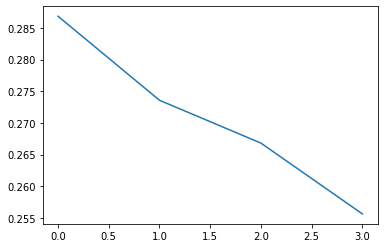

In [ ]:
import matplotlib.pyplot as plt

print(history)

plt.plot(history)
plt.show()

asdpomadsmlasdmdsammdasmadsmoad


## Validation loop [with batches]

In [ ]:
valid_history = [0.289786, 0.2864188751459122, 0.28497075259685517, 0.28590939280192057]
batch_size = 4
min_valid_loss = valid_history[-1]
# min_valid_loss = np.inf

In [ ]:
val_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
valid_loss = 0.0
  
# loop on all batches
for idx, batch in enumerate(val_dataloader):

  batch_loss = 0.0
  cur_batch_size = len(batch['file'])

  if idx% 500 == 0:
    print(f'current batch = {idx}')
  
  # do training
  try:
      # audio = getAudioSegment(data, audio_folder_path).to(device=device)
      audio = prepare_audio_batch(batch, device)
      text = batch['text']

      # convert target "punctuated" text to embedding
      target = prepare_target_batch(batch['raw_text'])

      # forward propagation
      scores = muse_model(text, audio)
      # print(f'Scores shape {scores.shape}')
      # print(f'Target shape {target.shape}')

      # Computing loss
      # loss = criterion(scores.clone().detach(), target)
      loss = criterion(scores, target[:,:scores.shape[-1]].long())

      batch_loss += float(loss.item())
  except Exception as ex:
      print(idx, ex)
      continue
  valid_loss += batch_loss

gc.collect()
valid_loss /= (len(valid_dataset)/batch_size)
valid_history.append(valid_loss)

current batch = 0
3 Expected target size [4, 34], got [4, 33]
48 Expected target size [4, 20], got [4, 19]
118 CUDA out of memory. Tried to allocate 962.00 MiB (GPU 0; 14.76 GiB total capacity; 11.72 GiB already allocated; 857.75 MiB free; 12.51 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
168 CUDA out of memory. Tried to allocate 1.36 GiB (GPU 0; 14.76 GiB total capacity; 11.96 GiB already allocated; 619.75 MiB free; 12.74 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
200 CUDA out of memory. Tried to allocate 846.00 MiB (GPU 0; 14.76 GiB total capacity; 10.61 GiB already allocated; 619.75 MiB free; 12.74 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try 

[0.289786, 0.2864188751459122, 0.28497075259685517, 0.28590939280192057]


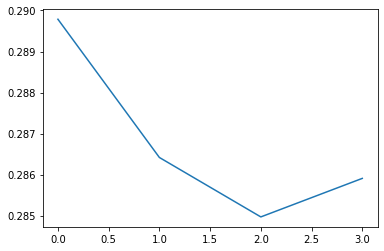

In [ ]:
import matplotlib.pyplot as plt

print(valid_history)

plt.plot(valid_history)
plt.show()

In [ ]:
if valid_history[-1] < min_valid_loss:
    print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_history[-1]:.6f}) \t Saving The Model')
    min_valid_loss = valid_history[-1]
    torch.save(muse_model.state_dict(), f'/content/drive/MyDrive/MuSe model/saved_model_batch{batch_size}.pth')

# save directly
# torch.save(muse_model.state_dict(), f'/content/drive/MyDrive/MuSe model/saved_model_batch{batch_size}.pth')


HOW TO CALCULATE `CLASSIFICATION REPORT` FOR THE VALIDATION DATASET??

## Overfitting on a small dataset

In [ ]:
history = []
batch_size = 4
epochs = 10
min_train_loss = np.inf
# min_train_loss = history[-1]

In [ ]:
for e in range(epochs):
  dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  train_loss = 0.0
  
  # loop on all batches
  for idx, batch in enumerate(dataloader):

    batch_loss = 0.0
    cur_batch_size = len(batch['file'])

    if idx% 500 == 0:
      print(f'current batch = {idx}')
    
    # do training
    try:
        # audio = getAudioSegment(data, audio_folder_path).to(device=device)
        audio = prepare_audio_batch(batch, device)
        text = batch['text']

        # convert target "punctuated" text to embedding
        target = prepare_target_batch(batch['raw_text'])

        # forward propagation
        scores = muse_model(text, audio)
        # print(f'Scores shape {scores.shape}')
        # print(f'Target shape {target.shape}')

        # Computing loss
        # loss = criterion(scores.clone().detach(), target)
        loss = criterion(scores, target[:,:scores.shape[-1]].long())

        # zero previous gradients
        optimizer.zero_grad()
                
        # back-propagation
        # loss.requires_grad = True
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

        # free some memory
        del audio, text

        batch_loss += float(loss.item())
    except Exception as ex:
        print(idx, ex)
        continue
    train_loss += batch_loss
  
  gc.collect()
  train_loss /= (len(train_dataset)/batch_size)
  history.append(train_loss)

  # deciding on saving the model
  print(f'Epoch {e+1} \t\t Training Loss: {train_loss}')
  if min_train_loss > train_loss:
        print(f'Train Loss Decreased({min_train_loss:.6f}--->{train_loss:.6f}) \t "NOT" Saving The Model')
        # min_valid_loss = valid_loss
        min_train_loss = train_loss
        # Saving State Dict
        # torch.save(muse_model.state_dict(), f'/content/drive/MyDrive/MuSe model/saved_model_batch{batch_size}.pth')

current batch = 0
Epoch 1 		 Training Loss: 0.11292146854102611
current batch = 0
Epoch 2 		 Training Loss: 0.10887769341468811
current batch = 0
Epoch 3 		 Training Loss: 0.10274148751050234
current batch = 0
Epoch 4 		 Training Loss: 0.09293171614408494
Train Loss Decreased(0.097409--->0.092932) 	 "NOT" Saving The Model
current batch = 0
Epoch 5 		 Training Loss: 0.10808212239295244
current batch = 0
Epoch 6 		 Training Loss: 0.11457607716321945
current batch = 0
8 Expected target size [4, 29], got [4, 28]
Epoch 7 		 Training Loss: 0.09503301180899143
current batch = 0
5 Expected target size [4, 29], got [4, 28]
Epoch 8 		 Training Loss: 0.10913577660918236
current batch = 0
Epoch 9 		 Training Loss: 0.12028297811746597
current batch = 0
Epoch 10 		 Training Loss: 0.09990887835621834


data size = 1000 , lr = 3e-4
- 10 epochs 0.285 -> 0.199
- 10 epochs 0.199 -> 0.179

data size = 100 , lr = 3e-4
- 50 epochs 0.76 -> 0.09

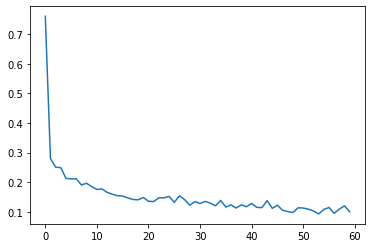

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history)
plt.show()

In [ ]:
torch.save(muse_model.state_dict(), f'/content/drive/MyDrive/MuSe model/saved_model_batch4_overfitting on 100.pth')


# Calculate corpus distribution

In [ ]:
dist_dict = {'nopunct': 0,
             'comma': 0,
             'period': 0,
             'question': 0}

raw_list = df_train['raw_text'][:15000].tolist()


In [ ]:
for raw in raw_list:
  try:
    tags = text_to_punct_embedding(raw, lexical_encoder.tokenizer)
    for tag in tags:
      if tag == 0:
        dist_dict['nopunct'] += 1
      elif tag == 1:
        dist_dict['comma'] += 1
      elif tag == 2:
        dist_dict['period'] += 1
      elif tag == 3:
        dist_dict['question'] += 1
  except:
    print('err')
    continue

print(dist_dict)

{'nopunct': 341280, 'comma': 20655, 'period': 3172, 'question': 535}


In [ ]:
s = float(sum(dist_dict.values()))
print(f'nopunct = {(dist_dict["nopunct"]/s)*100}%')
print(f'comma = {(dist_dict["comma"]/s)*100}%')
print(f'period = {(dist_dict["period"]/s)*100}%')
print(f'question = {(dist_dict["question"]/s)*100}%')

nopunct = 93.33719868067672%
comma = 5.648968116354248%
period = 0.8675152198051647%
question = 0.14631798316385974%


# F1 scores

https://torchmetrics.readthedocs.io/en/stable/classification/f1_score.html

In [ ]:
!pip install torchmetrics


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 418 kB 4.2 MB/s 


In [ ]:
from torchmetrics import F1Score
target = torch.empty(128, 38, dtype=torch.long).random_(4)
preds = torch.randn(128, 4, 38)
f1 = F1Score(num_classes=5, average='none', ignore_index=-100, mdmc_average='samplewise')
f1(preds, target)

ValueError: ignored

# copying models over to drive

In [ ]:
%cd /
%cp -r root/.cache/huggingface '/content/drive/MyDrive/Colab Notebooks/MuSe notebook models'

/
